### ToDo
* changing resource state 
* changing setup for each op 
    * may not required as you have the current operation with the req setup
    * and we do not consider setup times.
* monitoring the basics
* Material (Charge, Qualität, usw)
* Vorgänger (und Nachfolger) auf der Maschine speichern (vollständige Historie) --> Erweiterung: Stack/Queue mit "x Elementen" oder einen "x Zeitraum"
* alternative Maschine aus Maschinengruppe nutzen (optional?)
* Giffler - offene Operationen für die Inferencing
* run-event selbst bauen warten bis zum Endschritt 


Wie macht man Effekte sichtbar?
Qualitätsstufen von Materialen

In [1]:
from plan.GifflerThompson import GifflerThompson
from plan.HodgsonMoore import HodgsonMooreAlgorithm
from factory.Operation import Operation
from simulation.Simulator import Simulator
from causal.causal_model import CausalModel
from generators.jobs_data_generator import JobsDataGenerator
import random

import pandas as pd
# Beispielhafte Datenstruktur
template_jobs_data = [
    ['p1', 1, 'a1', 1, 30, 4],
    ['p1', 2, 'a2', 1, 45, 4],
    ['p1', 3, 'a1', 2, 15, 4],
    ['p1', 4, 'a3', 1, 15, -1],
    ['p2', 1, 'a1', 1, 15, 3],
    ['p2', 2, 'a4', 2, 45, 3],
    ['p2', 3, 'a3', 2, 15, 5],
    ['p2', 4, 'a2', 1, 30, 5],
    ['p2', 5, 'a4', 1, 15, -1],
    
#    ['p1', 1, 'a1', 17, 2],
#    ['p1', 2, 'a2', 30, 4],
#    ['p1', 3, 'a3', 14, 4],
#    ['p1', 4, 'a4', 15, 5],
#    ['p1', 5, 'a5', 25, -1],
#    ['p2', 1, 'a1', 13, 3],
#    ['p2', 2, 'a3', 15, 3],
#    ['p2', 3, 'a2', 10, 4],
#    ['p2', 4, 'a6', 20, -1],
]

generator = JobsDataGenerator(template_jobs_data)
num_instances = 50  # Number of new instances to generate
relation = {'p1': 0.5, 'p2': 0.5}  # Relation of each product type

jobs_data = generator.generate_jobs_data(num_instances, relation)

# Maschinenpools definieren
# id, number, tools 
machine_pools_data = [
    ['a1', 4, [1,2,3]],
    ['a2', 4, [1,2,3]],
    ['a3', 4, [1,2,3]],
    ['a4', 4, [1,2,3]],
#    ['a5', 1, [1,2,3]],
#    ['a6', 1, [1,2,3]],
]

# Konvertiere die jobs_data in Operation-Objekte
operations_causal = [Operation(*data) for data in jobs_data]
operations_non_causal = [Operation(*data) for data in jobs_data]

# Define a priority rule
def calculate_dynamic_priority(operation) -> int:
    # Priorität basierend auf der geplanten Startzeit der Vorgängeraufgaben
    if not operation.predecessor_operations:
        return operation.plan_start if operation.plan_start is not None else 0
    else:
        return max(pred.plan_start for pred in operation.predecessor_operations) + operation.duration

# causal model
observed_data = []
csv_file = 'data/observed_data.csv'
model = CausalModel(csv_file=csv_file)
#model = CausalModelPyMC(csv_file=csv_file)
# Causal model for simulation
# define an inference rule    
def simulation_inference(operation: Operation) -> int:
 
    # 1. Preperation step
    #has_lots_operations = len(operation.predecessor_operations) > 1
    #is_shorter_than_15 =  operation.plan_duration < 15
    #filtered_pools = [pool for pool in sim.pools.values() if pool.group == operation.machine.group and pool.id != operation.machine.id]
    #one_working = any(pool.current_operation is not None for pool in filtered_pools) 
    

    

    # 2. Infer step
    duration_factor = model.infer_duration(True, operation)

    # 3. Calculation step
    new_duration = round(operation.duration * duration_factor,0)
    
    # Save for causal learning
    observed_data.append([len(operation.predecessor_operations), operation.req_machine_group_id, duration_factor])
    
    print(f"Operation duration was: {operation.duration} and has been changed to {new_duration}")
    return new_duration

# Causal model for planning
# define an inference rule    
def plan_inference(operation: Operation) -> int:
        
    # 2. Infer step
    duration_factor = model.infer_duration(False, operation)

    new_duration = round(operation.duration * duration_factor,0)

    return new_duration

# Causal model for planning
# define an inference rule    
def plan_inference_non(operation: Operation) -> int:
    return operation.duration

#hodgens = HodgsonMooreAlgorithm()
#hodgens_schedule = hodgens.schedule_jobs(operations_non_causal, machine_pools_data)

# Führe den Giffler Thompson Algorithmus aus
gt = GifflerThompson(calculate_dynamic_priority, plan_inference)
gt_causal_schedule = gt.giffen_thompson(operations_causal, machine_pools_data)

# Führe den Giffler Thompson Algorithmus aus
non_causal = GifflerThompson(calculate_dynamic_priority, plan_inference_non)
gt_non_causal_schedule = non_causal.giffen_thompson(operations_non_causal, machine_pools_data)


/home/marvin/repo/PlanCausal/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 1/1000000 [00:00<5:22:56, 51.61it/s]


TypeError: plan_inference() takes 1 positional argument but 2 were given

In [9]:
from simulation.Simulator import Simulator
from simulation.Monitoring.BasicMonitor import monitorResource
from functools import partial

# array to store monitored data
data = []

# resource monitor [pre , post] execution
monitor = [None, partial(monitorResource, data)]

sim = Simulator(machine_pools_data
                , operations_non_causal
                , monitor
                , simulation_inference)

sim.env.run(12000)

165
90
195
210
285
240
300
270
345
330
225
375
420
450
345
420
360
465
360
435
375
480
375
225
390
450
480
375
225
390
450
480
0
0
45
0
225
0
0
0
45
0
0
15
45
15
0
30
45
30
0
60
30
240
30
0
60
45
255
45
45
45
90
45
45
45
90
60
60
60
105
75
75
75
120
75
0
90
90
270
90
90
90
135
90
45
105
105
270
105
120
105
165
105
45
120
120
270
120
45
135
135
270
120
135
120
180
135
150
135
195
135
165
150
210
150
165
165
210
165
45
180
180
285
180
90
210
195
285
180
210
180
255
180
210
195
255
195
90
210
225
285
210
240
210
285
210
255
210
300
225
90
240
255
300
225
135
240
255
300
240
285
240
330
240
135
255
285
315
255
285
255
330
270
315
270
360
285
330
285
375
285
330
300
375
300
135
315
345
375
315
135
330
360
390
315
180
345
375
405
315
180
345
375
405
315
375
330
420
330
180
360
390
420
345
180
375
405
435
345
405
345
450
0, job: p10, operation_id: 1, getting resource
0, job: p10, operation_id: 2, getting resource
0, job: p10, operation_id: 4, getting resource
0, job: p11, operation_id: 1, get

## Some statistics to compare the plan

In [10]:
import pandas as pd

def calculate_makespan(df_schedule, schedule_name):
    # Convert the list of operation objects to a DataFrame
    

    # Calculate start and end times for each job
    grouped_schedule = df_schedule.groupby('job_id').agg({'start_time': 'min', 'end_time': 'max'})

    # Calculate the makespan for each job
    grouped_schedule['makespan'] = grouped_schedule['end_time'] - grouped_schedule['start_time']

    # Calculate the average makespan across all jobs
    average_makespan = grouped_schedule['makespan'].mean()

    # Output the results with the schedule name
    print(f"The average makespan across all products in the {schedule_name} schedule is: {average_makespan} time units.")

# Example usage with named schedules
calculate_makespan(pd.DataFrame([op.to_dict() for op in gt_non_causal_schedule]), 'NonCausal')
calculate_makespan(pd.DataFrame([op.to_dict() for op in gt_causal_schedule]), 'Causal')
calculate_makespan(pd.DataFrame([op.to_dict_sim() for op in sim.schedule]), 'Sim')



The average makespan across all products in the NonCausal schedule is: 159.0 time units.
The average makespan across all products in the Causal schedule is: 175.16 time units.
The average makespan across all products in the Sim schedule is: 171.16 time units.


In [11]:
df_observed_data = pd.DataFrame(observed_data, columns=['operation_pres_count' , 'operation_req_machine', 'operation_duration'])
df_observed_data.to_csv("data/observed_data.csv")

GT without causal

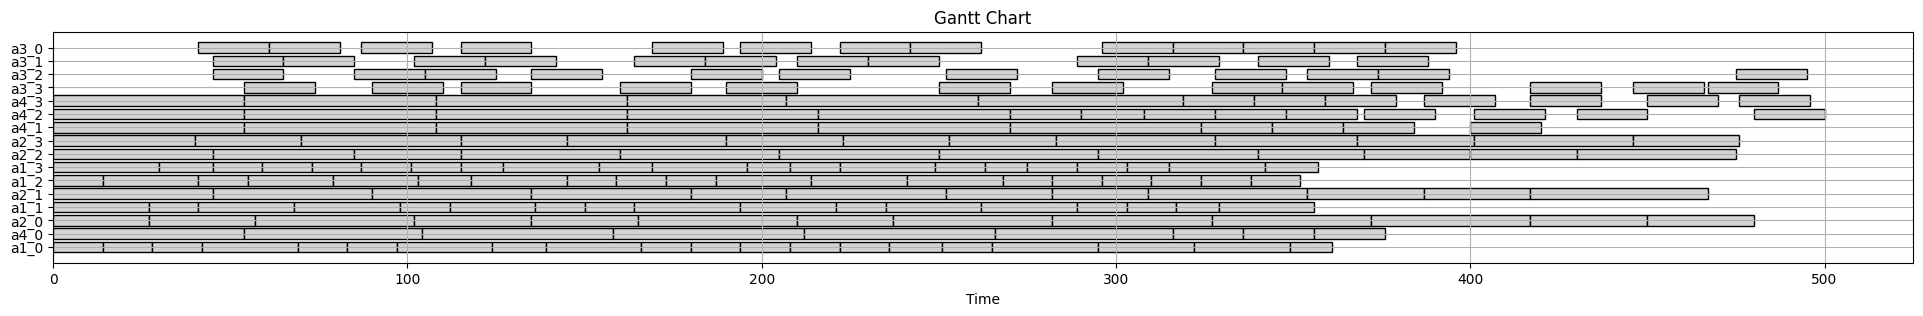

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import math

# Daten in ein DataFrame konvertieren
df = pd.DataFrame([p.to_dict() for p in gt_causal_schedule])

size_height = math.ceil(df["machine"].count().itemsize / 3)
# Gantt-Diagramm erstellen
fig, ax = plt.subplots(figsize=(24, size_height))

# Maschinen als y-Werte für die Balken
machines = df['machine'].unique()
machine_to_y = {machine: i for i, machine in enumerate(machines)}

# Iteriere über jede Zeile des DataFrames
for i, row in df.iterrows():
    start = row['start_time']
    duration = row['plan_duration']
    job_id = row['job_id']
    task_id = row['operation_id']
    machine = row['machine']
    label = f'{job_id} {task_id}'

    # Stelle die Aufgabe als Balken im Diagramm dar
    ax.barh(y=machine_to_y[machine], left=start, width=duration, height=0.8, align='center', color='lightgrey', edgecolor='black')
    
    # Text in den Balken einfügen
    #ax.text(x=start + duration / 2, y=machine_to_y[machine], s=label, va='center', ha='center', color='black')

# Diagramm formatieren
ax.set_xlabel('Time')
ax.set_yticks(list(machine_to_y.values()))
ax.set_yticklabels(list(machine_to_y.keys()))
ax.set_title('Gantt Chart')

# Grid anzeigen
ax.grid(True)

# Legende entfernen, da sie nicht mehr notwendig ist
# Handles und Labels der Legende deduplizieren
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

# Diagramm anzeigen
plt.show()


Sim result

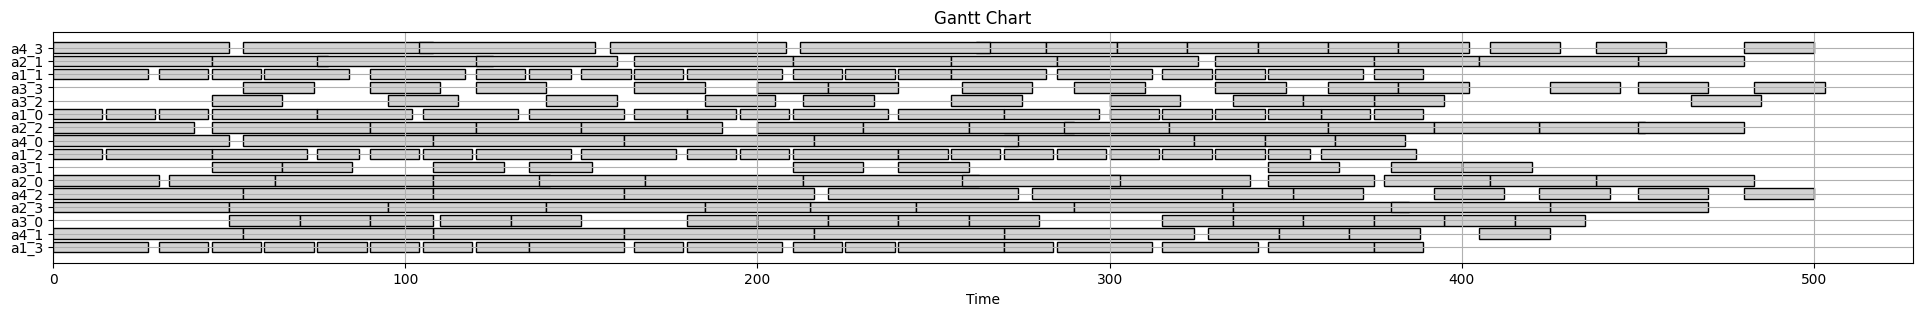

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import math

# Daten in ein DataFrame konvertieren
df = pd.DataFrame([op.to_dict_sim() for op in sim.schedule])

size_height = math.ceil(df["machine"].count().itemsize / 3)
# Gantt-Diagramm erstellen
fig, ax = plt.subplots(figsize=(24, size_height))

# Maschinen als y-Werte für die Balken
machines = df['machine'].unique()
machine_to_y = {machine: i for i, machine in enumerate(machines)}

# Iteriere über jede Zeile des DataFrames
for i, row in df.iterrows():
    start = row['start_time']
    duration = row['duration']
    job_id = row['job_id']
    task_id = row['operation_id']
    machine = row['machine']
    label = f'{job_id} {task_id}'

    # Stelle die Aufgabe als Balken im Diagramm dar
    ax.barh(y=machine_to_y[machine], left=start, width=duration, height=0.8, align='center', color='lightgrey', edgecolor='black')
    
    # Text in den Balken einfügen
    #ax.text(x=start + duration / 2, y=machine_to_y[machine], s=label, va='center', ha='center', color='black')

# Diagramm formatieren
ax.set_xlabel('Time')
ax.set_yticks(list(machine_to_y.values()))
ax.set_yticklabels(list(machine_to_y.keys()))
ax.set_title('Gantt Chart')

# Grid anzeigen
ax.grid(True)

# Legende entfernen, da sie nicht mehr notwendig ist
# Handles und Labels der Legende deduplizieren
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

# Diagramm anzeigen
plt.show()


GT with Causal

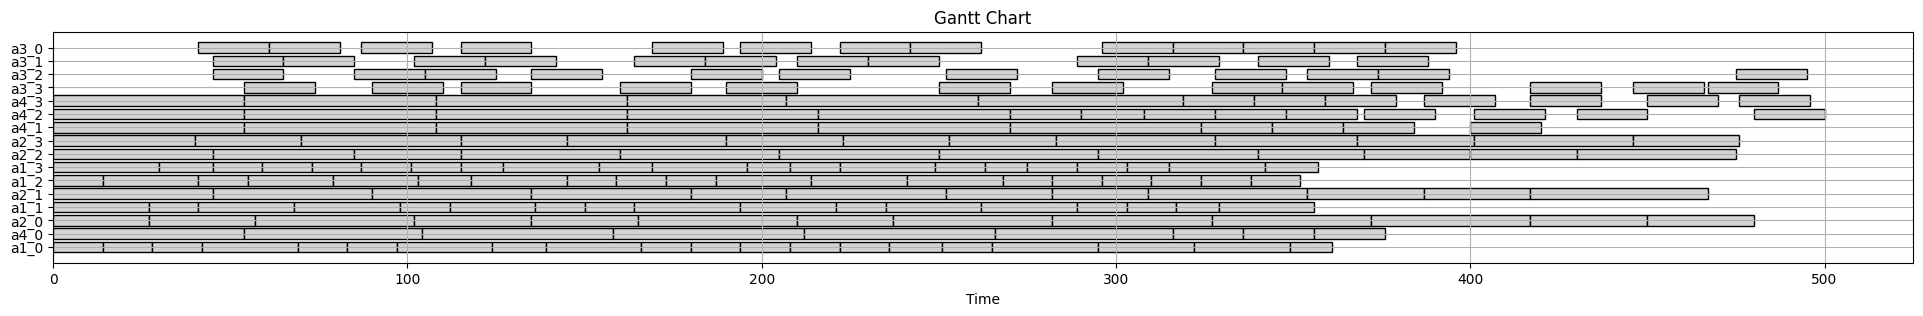

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import math

# Daten in ein DataFrame konvertieren
df = pd.DataFrame([p.to_dict() for p in gt_causal_schedule])

size_height = math.ceil(df["machine"].count().itemsize / 3)
# Gantt-Diagramm erstellen
fig, ax = plt.subplots(figsize=(24, size_height))

# Maschinen als y-Werte für die Balken
machines = df['machine'].unique()
machine_to_y = {machine: i for i, machine in enumerate(machines)}

# Iteriere über jede Zeile des DataFrames
for i, row in df.iterrows():
    start = row['start_time']
    duration = row['plan_duration']
    job_id = row['job_id']
    task_id = row['operation_id']
    machine = row['machine']
    label = f'{job_id} {task_id}'

    # Stelle die Aufgabe als Balken im Diagramm dar
    ax.barh(y=machine_to_y[machine], left=start, width=duration, height=0.8, align='center', color='lightgrey', edgecolor='black')
    
    # Text in den Balken einfügen
    #ax.text(x=start + duration / 2, y=machine_to_y[machine], s=label, va='center', ha='center', color='black')

# Diagramm formatieren
ax.set_xlabel('Time')
ax.set_yticks(list(machine_to_y.values()))
ax.set_yticklabels(list(machine_to_y.keys()))
ax.set_title('Gantt Chart')

# Grid anzeigen
ax.grid(True)

# Legende entfernen, da sie nicht mehr notwendig ist
# Handles und Labels der Legende deduplizieren
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

# Diagramm anzeigen
plt.show()
